## Общее описание:

Компания занимается доставкой продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Маркетинг-менеджер попросил проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 
Есть данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

### План:
1. Посчитать, у какой когорты пользователей самая большая конверсия из установки в покупку в течение 7 дней
2. С какого платного маркетингового канала пришло больше всего новых пользователей?
3. Проанализировать, на каком этапе воронки отваливается бОльшая часть зарегистрированных клиентов.
4. Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?
5. Пользователи, пришедшие с какого канала, имеют медианный первый чек выше?
6. Какой платный канал привлечения имеет самый высокий ROMI?

### Описание данных 

- `date` – дата совершения события
- `event` – событие
    * app_install – установка приложения
    * app_start – открыть приложения
    * register – зарегистрироваться 
    * search – перейти на страницу поиска товаров (каталог)
    * open_item – открыть товар
    * choose_item – отправить товар в корзину
    * tap_basket – перейти в корзину
    * purchase – подтверждение покупки

- `gender` – пол пользователя
- `os_name` – платформа пользователя
- `city` – город пользователя
- `device_id` – идентификатор устройства пользователя
- `urm_source` – канал, с которого пришел пользователь
    * yandex-direct – Яндекс директ
    * google_ads – реклама в Google
    * vk_ads – реклама в ВК
    * instagram_ads – реклама в instagram
    * facebook_ads – реклама в facebook
    * referral – акция «приведи друга»
    * Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы 
    
- `purchase_sum` – стоимость покупки (при совершении события ‘purchase’)

Важно:

- В выгрузке только уникальные действия пользователей за каждый день 

- Можно миновать стадию установки приложения, если оно было установлено ранее

- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

In [1]:
import pandas as pd
import datetime
import seaborn as sns

In [2]:
app_data = pd.read_csv('KC_case_data.csv')

In [3]:
app_data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [4]:
app_data.shape

(2747968, 8)

In [5]:
app_data.describe()

,purchase_sum,device_id
count,141383.000000,2.747968e+06
mean,709.116092,1.090841e+07
std,1289.458186,9.871445e+06
min,61.000000,4.013000e+03
25%,226.500000,1.975336e+06
50%,394.000000,8.731416e+06
75%,560.500000,1.736726e+07
max,7884.000000,3.539777e+07


In [6]:
app_data.dtypes

date             object
event            object
purchase_sum    float64
os_name          object
device_id         int64
gender           object
city             object
utm_source       object
dtype: object

## 1. конверсия из установки в покупку

In [7]:
# Присвоим пользователям когорты по дню установки приложения и посчитаем для них  конверсию из установки в покупку 
# в течение 7 дней. Для какой когорты конверсия была наибольшей?

In [8]:
# отбираем device_id, по которым были установки. install_date = когорта пользователя
installs = app_data.query('event == "app_install"').rename(columns={'date': 'install_date'})
installs = installs.drop(['event', 'purchase_sum'], 1)
installs.head()

,install_date,os_name,device_id,gender,city,utm_source
2515061,2020-01-01,ios,4921563,male,Moscow,vk_ads
2515062,2020-01-01,ios,1311583,male,Moscow,-
2515063,2020-01-01,android,23006325,male,Saint-Petersburg,-
2515064,2020-01-01,android,5645652,male,Moscow,-
2515065,2020-01-01,ios,8798567,male,Saint-Petersburg,referal


In [9]:
# считаем кол-во установок по когортам
installs_by_cohort = installs \
                            .groupby('install_date', as_index=False) \
                            .agg({'device_id': 'count'}) \
                            .rename(columns={'device_id': 'installs'})
installs_by_cohort.head()

,install_date,installs
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671


In [10]:
# отбираем device_id, по которым были покупки, и дату их первой покупки
purchases = app_data \
                    .query('event == "purchase"') \
                    .rename(columns={'date': 'purchase_date'}) \
                    .groupby('device_id', as_index=False) \
                    .agg({'purchase_date': 'min', 'purchase_sum': 'sum'})
purchases.head()

,device_id,purchase_date,purchase_sum
0,4014,2020-02-01,1662.0
1,4046,2020-01-04,2718.0
2,4060,2020-03-07,172.5
3,4120,2020-01-07,1723.5
4,4125,2020-01-07,1089.5


In [11]:
# получаем ДФ, где есть когорта пользователя (install_date) и дата его первой покупки (purchase_date)
converted_to_purchase = installs.merge(purchases, how='inner', on='device_id')
converted_to_purchase.head()

,install_date,os_name,device_id,gender,city,utm_source,purchase_date,purchase_sum
0,2020-01-01,ios,4921563,male,Moscow,vk_ads,2020-01-10,4049.5
1,2020-01-01,android,23006325,male,Saint-Petersburg,-,2020-01-01,479.5
2,2020-01-01,android,8423608,female,Saint-Petersburg,referal,2020-01-06,1101.5
3,2020-01-01,android,532710,male,Moscow,yandex-direct,2020-01-03,8444.0
4,2020-01-01,android,528071,female,Saint-Petersburg,vk_ads,2020-01-02,4883.0


In [12]:
# чтобы найти разницу между purchase_date и install_date, переводим их в тип datetime
converted_to_purchase.install_date = pd.to_datetime(converted_to_purchase.install_date)
converted_to_purchase.purchase_date = pd.to_datetime(converted_to_purchase.purchase_date)

In [13]:
converted_to_purchase['diff_date'] = converted_to_purchase.purchase_date - converted_to_purchase.install_date

In [14]:
# т.к. у diff_date тип timedelta, переводим его в int (кол-во дней)
converted_to_purchase['diff_date'] = converted_to_purchase['diff_date'].apply(lambda x: x.days)

In [15]:
# оставляем только тех пользователей, у кого diff_date от 0 до 7 дней
# для них по каждой когорте считаем кол-во пользователей, совершивших покупку
purchases_by_cohort = converted_to_purchase \
                                    .query('diff_date < 8') \
                                    .groupby('install_date', as_index=False) \
                                    .agg({'purchase_date': 'count'}) \
                                    .rename(columns={'purchase_date': 'purchases'})
purchases_by_cohort.head()

,install_date,purchases
0,2020-01-01,1408
1,2020-01-02,1186
2,2020-01-03,834
3,2020-01-04,639
4,2020-01-05,587


In [16]:
installs_by_cohort.install_date = pd.to_datetime(installs_by_cohort.install_date)

In [17]:
# собираем итоговый ДФ, где есть когорта (install_date), кол-во пользователей, совершивших установку, 
# кол-во пользователей, совершивших покупку
cr_7_days = installs_by_cohort.merge(purchases_by_cohort, on='install_date', how='left')

In [18]:
installs_by_cohort.shape

(91, 2)

In [19]:
cr_7_days.shape

(91, 3)

In [20]:
# считаем конверсию из установки в покупку
cr_7_days['cr'] = cr_7_days.purchases / cr_7_days.installs

In [21]:
cr_7_days.sort_values('cr', ascending=False)
# самая высокая конверсия у когорты "2020-01-01"

,install_date,installs,purchases,cr
0,2020-01-01,3579,1408,0.393406
8,2020-01-09,1424,558,0.391854
14,2020-01-15,4310,1650,0.382831
13,2020-01-14,5173,1973,0.381403
1,2020-01-02,3144,1186,0.377226
...,...,...,...,...
77,2020-03-18,1171,235,0.200683
88,2020-03-29,1117,223,0.199642
81,2020-03-22,1261,251,0.199048
87,2020-03-28,1091,209,0.191567


<AxesSubplot:xlabel='install_date', ylabel='cr'>

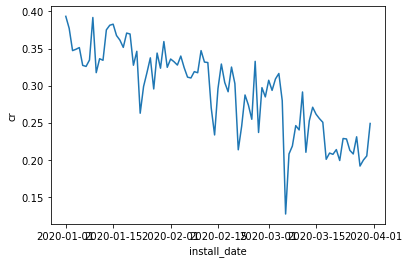

In [22]:
sns.lineplot(data=cr_7_days, x='install_date', y='cr')
# видим тренд на падение конверсии

## 2. с какого платного маркетингового канала пришло больше всего новых пользователей? 

In [23]:
installs.utm_source.value_counts()
# с Яндекса

-                32460
yandex-direct    29368
google_ads       26286
vk_ads           23189
instagram_ads    20096
facebook_ads     13916
referal           9282
Name: utm_source, dtype: int64

## 3. анализ воронки

In [24]:
# Посмотрим, на каком шаге отваливается больше всего зарегистрированных пользователей? 

In [25]:
app_data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [26]:
# найдем дату регистрации для каждого пользователя
registrate_date = app_data.query('event == "register"')[['date', 'device_id']].rename(columns={'date': 'register_date'})
registrate_date.head()

,register_date,device_id
2669658,2020-01-01,294193
2669659,2020-01-01,22917617
2669660,2020-01-01,15248490
2669661,2020-01-01,252062
2669662,2020-01-01,2251583


In [27]:
app_data = app_data.merge(registrate_date, on='device_id', how='left')

In [28]:
events = app_data \
                .query('register_date <= date') \
                .groupby('event', as_index=False) \
                .agg({'device_id': 'count'}) \
                .sort_values('device_id', ascending=False) \
                .rename(columns={'device_id': 'users'})
events

,event,users
1,app_start,519754
5,search,495411
2,choose_item,392783
6,tap_basket,295566
3,purchase,141383
4,register,78310
0,app_install,42448


In [29]:
events['cr_previous_event'] = events.users / events.users.shift()

In [30]:
events
# ответ: Переход в корзину (tap_basket)

,event,users,cr_previous_event
1,app_start,519754,NaN
5,search,495411,0.953164
2,choose_item,392783,0.792843
6,tap_basket,295566,0.752492
3,purchase,141383,0.478347
4,register,78310,0.553886
0,app_install,42448,0.542051


## 4. Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?

In [31]:
# посчитаем кол-во уникальных пользователей, зашедших в приложение, по каналам привлечения
first_app_start_by_utm = app_data \
                                .query('event == "app_start"') \
                                .sort_values('date') \
                                .drop_duplicates('device_id') \
                                .groupby('utm_source', as_index=False) \
                                .agg({'device_id': 'count'}) \
                                .rename(columns={'device_id': 'users_app_start'})
first_app_start_by_utm

,utm_source,users_app_start
0,-,41456
1,facebook_ads,18844
2,google_ads,31437
3,instagram_ads,24818
4,referal,11983
5,vk_ads,27905
6,yandex-direct,34441


In [32]:
# посчитаем кол-во уникальных пользователей, совершивших покупку, по каналам привлечения
first_purchase_by_utm = app_data \
                                .query('event == "purchase"') \
                                .sort_values('date') \
                                .drop_duplicates('device_id') \
                                .groupby('utm_source', as_index=False) \
                                .agg({'device_id': 'count', 'purchase_sum': 'median'}) \
                                .rename(columns={'device_id': 'users_purchase'})
first_purchase_by_utm

,utm_source,users_purchase,purchase_sum
0,-,14786,398.5
1,facebook_ads,7903,389.0
2,google_ads,10167,390.5
3,instagram_ads,9820,393.5
4,referal,5803,395.5
5,vk_ads,11460,393.0
6,yandex-direct,10936,392.5


In [33]:
# объединяем два ДФ, чтобы посчитать конверсию
cr_utm_source = first_app_start_by_utm.merge(first_purchase_by_utm, on='utm_source')

In [34]:
cr_utm_source['cr'] = cr_utm_source.users_purchase / cr_utm_source.users_app_start

In [49]:
cr_utm_source.sort_values('cr', ascending=False)
# самая низкая конверсия в покупку у пользователей с Яндекса

,utm_source,users_app_start,users_purchase,purchase_sum,cr
4,referal,11983,5803,395.5,0.484269
1,facebook_ads,18844,7903,389.0,0.419391
5,vk_ads,27905,11460,393.0,0.410679
3,instagram_ads,24818,9820,393.5,0.395681
0,-,41456,14786,398.5,0.356667
2,google_ads,31437,10167,390.5,0.323409
6,yandex-direct,34441,10936,392.5,0.317529


## 5. Пользователи, пришедшие с какого канала, имеют медианный первый чек выше?

In [36]:
first_purchase_by_utm.sort_values('purchase_sum', ascending=False)
# ответ: Реферальная программа

,utm_source,users_purchase,purchase_sum
0,-,14786,398.5
4,referal,5803,395.5
3,instagram_ads,9820,393.5
5,vk_ads,11460,393.0
6,yandex-direct,10936,392.5
2,google_ads,10167,390.5
1,facebook_ads,7903,389.0


## 6. Какой платный канал привлечения имеет самый высокий ROMI?

In [37]:
# Данные по затратам на рекламу:
# Яндекс – 10 491 707 руб.
# Гугл – 10 534 878 руб.
# Фейсбук – 8 590 498 руб.
# Инстаграм – 8 561626 руб.
# ВК – 9 553 531руб.

In [38]:
purchase_by_utm = app_data \
                        .query('event == "purchase"') \
                        .groupby('utm_source', as_index=False) \
                        .agg({'purchase_sum': 'sum'})
purchase_by_utm

,utm_source,purchase_sum
0,-,21449749.5
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


In [39]:
purchase_by_utm['marketing_costs'] = [0, 8590498, 10534878, 8561626, 0, 9553531, 10491707]

In [40]:
purchase_by_utm['romi'] = (purchase_by_utm.purchase_sum - purchase_by_utm.marketing_costs) / purchase_by_utm.marketing_costs

In [50]:
purchase_by_utm.sort_values('romi', ascending=False)

,utm_source,purchase_sum,marketing_costs,romi
0,-,21449749.5,0,inf
4,referal,8837044.5,0,inf
5,vk_ads,16389652.5,9553531,0.715560
3,instagram_ads,14546969.0,8561626,0.699090
1,facebook_ads,12249901.0,8590498,0.425983
6,yandex-direct,13915368.0,10491707,0.326321
2,google_ads,12868276.0,10534878,0.221493


In [42]:
# самый высокий ROMI у VK

## 7. Выводы

1. Самая высокая конверсия из установки в покупку в течение 7-ми дней у пользователей, установивших приложение 01.01.2020
2. С 01.01.2020 по 31.03.2020 наблюдается падение конверсии на 37%. 
3. Больше всего зарегистрированных пользователей отваливается на этапе из перехода в корзину в покупку
4. Самая низкая конверсия в покупку у пользователей, пришедших с Яндекса
5. Самая высокая конверсия в покупку у пользователей, пришедших по реферальной программе, Facebook и VK
6. Самый высокий медианный первый чек у пользователей, пришедших по реферальной программе
7. Самый высокий ROMI - у VK, самый низкий - у Гугл

Что можно сделать:
1. настроить мониторинг метрики конверсии и алерт при падении метрики на х% или ниже уровня х
2. понять, почему отваливаются пользователи при переходе из корзины в покупку. Возможно, есть баги в приложении. Если все работает, провести серию А/Б тестов, чтобы улучшить дизайн и наполнение страницы с корзиной (добавить информацию об условиях бесплатной доставки, возможностях оплаты, возврата товара, добавить возможность менять срок доставки и т.д.)
3. лучше таргетировать аудиторию с Яндекса
4. снизить бюджет или отказаться от рекламы в Гугл (низкая конверсия в покупку, низкий ROMI). Бюджет Гугла перераспределить на Instagram и VK (высокая конверсия в покупку, высокий ROMI)